In this notebook we are pereforming differnt Clustering model.

1. K-means
2. AGNES
3. DBSCAN

and comparing the them with the evaluation metric.

- Estimated number of Cluster
- Number of instances
- Estimated Noise
- Standard deviation of Clusters
- Homogeneity
- Completeness
- V-measure
- Rand Index
- Muatal Informatio
- Fowlkes-Mallows Score
- Silhouette Coefficient

The Final result metrics tables is avaliable in `result_table.xlsx` in clustering sheet.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn.cluster import DBSCAN 
import matplotlib.cm as cm
from plotly.offline import plot
from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# define a function to plot silhouette values of clusters
def silhouette_plot(X, y, n_clusters, ax=None):
    if ax is None:
        ax = plt.gca()

    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(X, y)
    sample_silhouette_values = silhouette_samples(X, y)

    y_lower = padding = 2
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        ith_cluster_silhouette_values = sample_silhouette_values[y == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0,
                         ith_cluster_silhouette_values,
                         facecolor=color,
                         edgecolor=color,
                         alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + padding

    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax.axvline(x=silhouette_avg, c='r', alpha=0.8, lw=0.8, ls='-')
    ax.annotate('Average',
                xytext=(silhouette_avg, y_lower * 1.025),
                xy=(0, 0),
                ha='center',
                alpha=0.8,
                c='r')

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_ylim(0, y_upper + 1)
    ax.set_xlim(-0.075, 1.0)
    return ax

In [ ]:
df_original = pd.read_pickle('/content/gdrive/MyDrive/Project/Data/whole_set_selected_preprocessed_normalized_fixed.pkl')

X = df_original.loc[:, ["n_EAR", 
                    "n_MAR", "n_MOE", "n_EC",
                    "n_LEB", "n_SOP", "PERCLOS", "CLOSENESS"]]

y = df_original.loc[:, "DROWSINESS"]

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])

In [ ]:
# PCA for reducing dimensions to 3
pca = PCA(n_components=3)
pca_X = pca.fit_transform(X)

# resample
r_X = resample(pca_X, n_samples=10000, replace=False, stratify=y, random_state=0)
r_y = resample(y, n_samples=10000, replace=False, stratify=y, random_state=0).to_numpy()

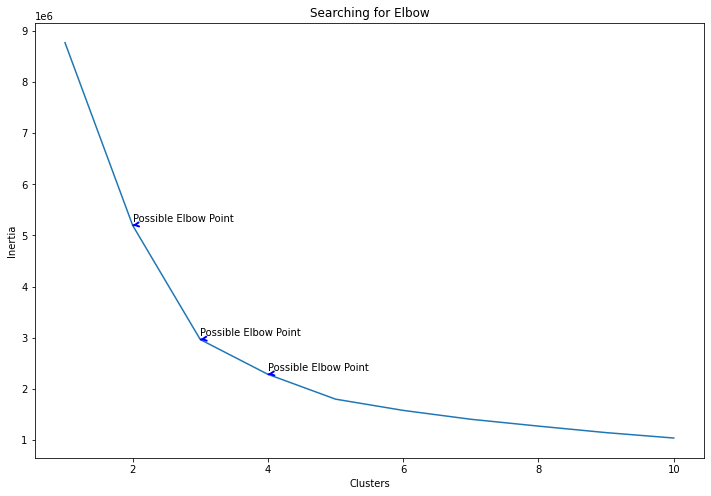

/usr/local/lib/python3.7/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `kmeans2` didn't end with .html. Adding .html to the end of your file.

/usr/local/lib/python3.7/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `kmeans3` didn't end with .html. Adding .html to the end of your file.

/usr/local/lib/python3.7/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `kmeans4` didn't end with .html. Adding .html to the end of your file.



([<matplotlib.patches.Wedge at 0x7f18589d6210>,
 [Text(-1.0999901403491903, 0.00465737421396925, '0'),
  Text(1.0999901403491903, -0.0046573742139693845, '1')],
 [Text(-0.5999946220086492, 0.0025403859348923177, '49.9%'),
  Text(0.5999946220086492, -0.002540385934892391, '50.1%')])

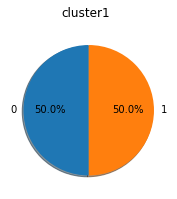

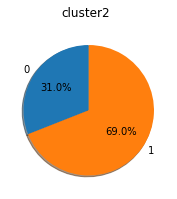

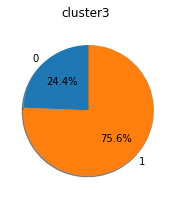

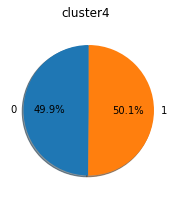

In [ ]:
clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(r_X)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow
ax.annotate('Possible Elbow Point', xy=(4, clusters[3]), xytext=(4, clusters[3]+80000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

ax.annotate('Possible Elbow Point', xy=(3,clusters[2] ), xytext=(3, clusters[2]+80000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

ax.annotate('Possible Elbow Point', xy=(2,clusters[1] ), xytext=(2, clusters[1]+80000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

# running k-means with 2 clusters on resuts of pca
km_pca2 = KMeans(n_clusters=2).fit(r_X)
# plot
fig = px.scatter_3d(x=r_X [:,0],y=r_X [:,1],z=r_X [:,2],color=colors[km_pca2.labels_])
plot(fig, filename = 'kmeans2', auto_open=True)

# running k-means with 3 clusters on resuts of pca
km_pca3 = KMeans(n_clusters=3).fit(r_X)
# plot
fig = px.scatter_3d(x=r_X [:,0],y=r_X [:,1],z=r_X [:,2],color=colors[km_pca3.labels_])
plot(fig, filename = 'kmeans3',auto_open=True)

# running k-means with 4 clusters on resuts of pca
km_pca4 = KMeans(n_clusters=4).fit(r_X)
# plot
fig = px.scatter_3d(x=r_X [:,0],y=r_X [:,1],z=r_X [:,2],color=colors[km_pca4.labels_])
plot(fig, filename = 'kmeans4',auto_open=True)

# for kmeans with 4 clusters is chosen so we calculate mean of clusters
indexes0 = np.where(km_pca4.labels_ == 0)
indexes1 = np.where(km_pca4.labels_ == 1)
indexes2 = np.where(km_pca4.labels_ == 2)
indexes3 = np.where(km_pca4.labels_ == 3)

mean_indexes0 = r_X[indexes0].mean(axis = 0)
mean_indexes1 = r_X[indexes1].mean(axis = 0)
mean_indexes2 = r_X[indexes2].mean(axis = 0)
mean_indexes3 = r_X[indexes3].mean(axis = 0)

mean_overall = r_X.mean(axis = 0)

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster1')
unique, counts = np.unique(r_y[indexes0[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster2')
unique, counts = np.unique(r_y[indexes1[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster3')
unique, counts = np.unique(r_y[indexes2[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster4')
unique, counts = np.unique(r_y[indexes3[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

/usr/local/lib/python3.7/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `agnes2` didn't end with .html. Adding .html to the end of your file.

/usr/local/lib/python3.7/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `agnes3` didn't end with .html. Adding .html to the end of your file.

/usr/local/lib/python3.7/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `agnes4` didn't end with .html. Adding .html to the end of your file.



([<matplotlib.patches.Wedge at 0x7f18589846d0>,
 [Text(-1.0636227583060844, -0.2805470156914111, '0'),
  Text(1.0636227583060842, 0.2805470156914115, '1')],
 [Text(-0.580157868166955, -0.15302564492258786, '58.2%'),
  Text(0.580157868166955, 0.15302564492258805, '41.8%')])

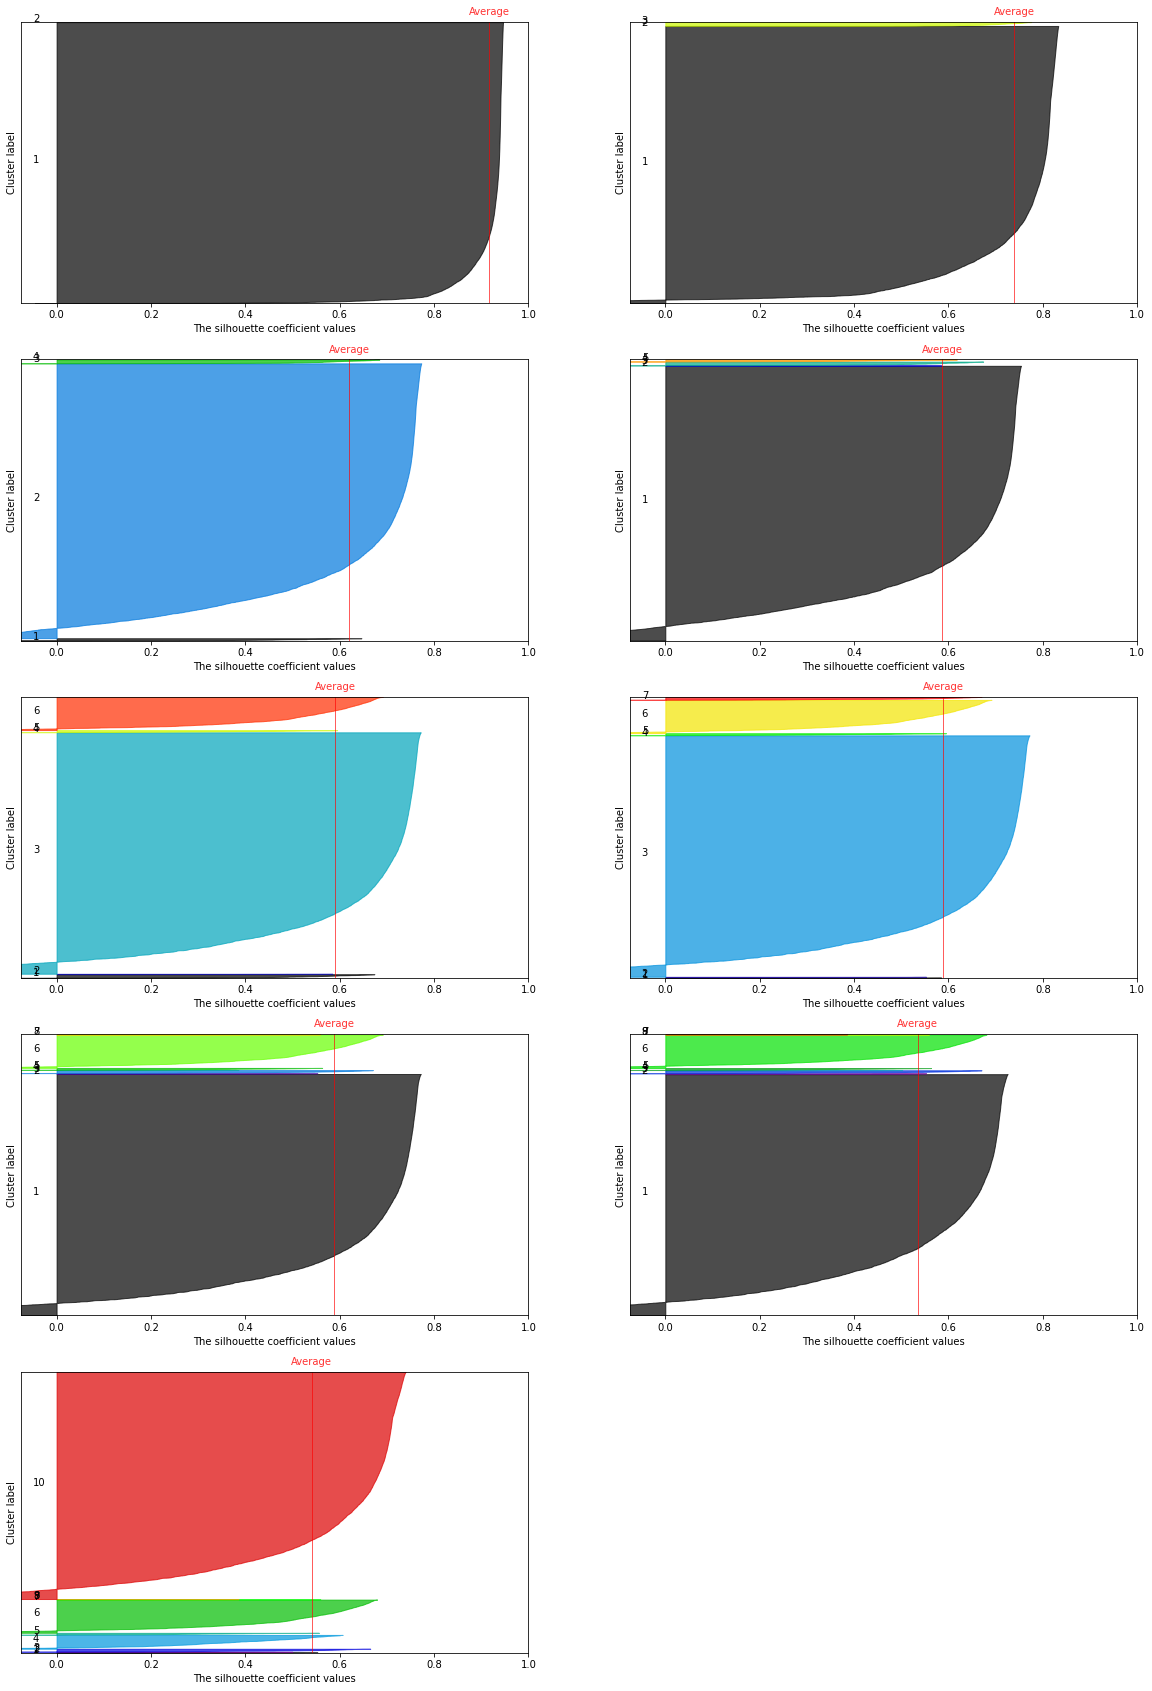

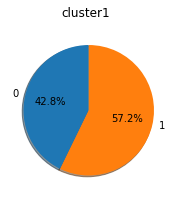

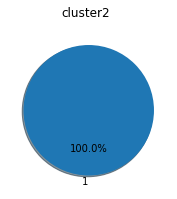

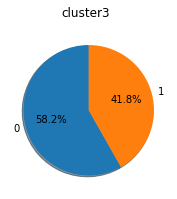

In [ ]:
# plot silhouette coefficients
plt.figure(figsize=(20,30))
for i in range(2,11):  
    agnes = AgglomerativeClustering(n_clusters=i, linkage='average')
    agnes_labels = agnes.fit_predict(r_X)
    plt.subplot(5,2,i-1)
    silhouette_plot(r_X,agnes_labels,i)
    
# 2 clusters
agnes2 = AgglomerativeClustering(n_clusters=2, linkage='average').fit(r_X)

# plot
fig = px.scatter_3d(x=r_X [:,0],y=r_X [:,1],z=r_X [:,2],color=colors[agnes2.labels_])
plot(fig, filename = 'agnes2',auto_open=True)

# 3 clusters
agnes3 = AgglomerativeClustering(n_clusters=3, linkage='average').fit(r_X)

# plot
fig = px.scatter_3d(x=r_X [:,0],y=r_X [:,1],z=r_X [:,2],color=colors[agnes3.labels_])
plot(fig, filename = 'agnes3',auto_open=True)

# 4 clusters
agnes4 = AgglomerativeClustering(n_clusters=4, linkage='average').fit(r_X)

# plot
fig = px.scatter_3d(x=r_X [:,0],y=r_X [:,1],z=r_X [:,2],color=colors[agnes4.labels_])
plot(fig, filename = 'agnes4',auto_open=True)

# for agnes with 3 clusters is chosen so we calculate mean of clusters
indexes0_agnes = np.where(agnes3.labels_ == 0)
indexes1_agnes = np.where(agnes3.labels_ == 1)
indexes2_agnes = np.where(agnes3.labels_ == 2)

mean_indexes0_agnes = r_X[indexes0_agnes].mean(axis = 0)
mean_indexes1_agnes = r_X[indexes1_agnes].mean(axis = 0)
mean_indexes2_agnes = r_X[indexes2_agnes].mean(axis = 0)

mean_overall = r_X.mean(axis = 0)

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster1')
unique, counts = np.unique(r_y[indexes0_agnes[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster2')
unique, counts = np.unique(r_y[indexes1_agnes[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster3')
unique, counts = np.unique(r_y[indexes2_agnes[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

/usr/local/lib/python3.7/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `dbscan` didn't end with .html. Adding .html to the end of your file.



([<matplotlib.patches.Wedge at 0x7f1857952990>],
 [Text(-2.0206672185931328e-16, -1.1, '1')],
 [Text(-1.1021821192326178e-16, -0.6, '100.0%')])

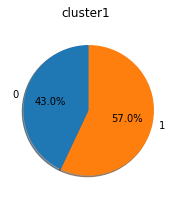

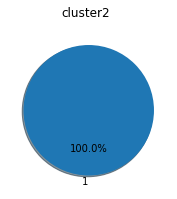

In [ ]:
# search for best parameters by using silhouette_score
score_list=[]
for eps in np.arange(0.5,20,0.5):
    for min_samples in range(3,20):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(r_X)
        labels = db.labels_
        n = len(np.unique(labels))
        if n>1:
            score=silhouette_score(r_X, labels)
            score_list.append((score,(eps,min_samples)))
     
biggest_score = sorted(score_list)[-1]  
best_eps, best_min_spamles = biggest_score[1]
best_eps, best_min_spamles

# best model for DBSCAN
db_best = DBSCAN(eps=best_eps, min_samples=best_min_spamles).fit(r_X)

# plot
fig = px.scatter_3d(x=r_X [:,0],y=r_X [:,1],z=r_X [:,2],color=colors[db_best.labels_])
plot(fig, filename = 'dbscan',auto_open=True)

# for dbscan 3 clusters is chosen so we calculate mean of clusters
indexes0_db = np.where(db_best.labels_ == 0)
indexes1_db = np.where(db_best.labels_ == -1)

mean_indexes0_db = r_X[indexes0_db].mean(axis = 0)
mean_indexes1_db = r_X[indexes1_db].mean(axis = 0)


mean_overall = r_X.mean(axis = 0)

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster1')
unique, counts = np.unique(r_y[indexes0_db[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

# A pie chart showing the instance distributions of each cluster as percentages
fig = plt.figure(figsize=(3,3))
fig.suptitle('cluster2')
unique, counts = np.unique(r_y[indexes1_db[0]], return_counts=True)
plt.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90) 

In [ ]:
# print metric for chosen models
models = [km_pca4, agnes3, db_best] 
names = ["K-MEANS:","AGNES:", "DBSCAN:"]

for i, model in enumerate(models):
    labels = model.labels_
    n = len(np.unique(labels))
    y = np.round(MinMaxScaler((0,n)).fit_transform(r_y.reshape(-1, 1))).ravel()
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    unique, counts = np.unique(labels, return_counts=True)
    value_counts=dict(zip(unique, counts))
    avg_count = counts.mean().round(decimals=2)
    value_counts['avg']=avg_count
    print(names[i])
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Number of instances in clusters: %s' % value_counts)
    print('Estimated number of noise points: %d' % n_noise_)
    for j in unique:
        indexes = np.where(labels == j)
        std_dev = r_X[indexes].std(axis = 0)
        print('Std of cluster %d: feature1: %.2f, feature2: %.2f, feature3: %.2f' % (j, std_dev[0],std_dev[1],std_dev[2]))
    print("Homogeneity: %0.3f" % homogeneity_score(y, labels))
    print("Completeness: %0.3f" % completeness_score(y, labels))
    print("V-measure: %0.3f" % v_measure_score(y, labels))
    print("Adjusted Rand Index: %0.3f"
          % adjusted_rand_score(y, labels))
    print("Adjusted Mutual Information: %0.3f"
          % adjusted_mutual_info_score(y, labels))
    print("Fowlkes-Mallows score: %0.3f"
          % fowlkes_mallows_score(y, labels))
    print("Silhouette Coefficient: %0.3f"
          % silhouette_score(r_X, labels))
    if model == km_pca4:
        print("Inertia (SSE): %d" % model.inertia_)
    print("\n")

K-MEANS:
Estimated number of clusters: 4
Number of instances in clusters: {0: 6646, 1: 936, 2: 2047, 3: 371, 'avg': 2500.0}
Estimated number of noise points: 0
Std of cluster 0: feature1: 5.01, feature2: 8.51, feature3: 5.99
Std of cluster 1: feature1: 14.10, feature2: 11.08, feature3: 6.37
Std of cluster 2: feature1: 9.18, feature2: 8.41, feature3: 6.06
Std of cluster 3: feature1: 19.75, feature2: 36.08, feature3: 10.16
Homogeneity: 0.037
Completeness: 0.027
V-measure: 0.031
Adjusted Rand Index: 0.005
Adjusted Mutual Information: 0.031
Fowlkes-Mallows score: 0.504
Silhouette Coefficient: 0.478
Inertia (SSE): 2284137


AGNES:
Estimated number of clusters: 3
Number of instances in clusters: {0: 9865, 1: 1, 2: 134, 'avg': 3333.33}
Estimated number of noise points: 0
Std of cluster 0: feature1: 22.00, feature2: 12.95, feature3: 6.17
Std of cluster 1: feature1: 0.00, feature2: 0.00, feature3: 0.00
Std of cluster 2: feature1: 12.48, feature2: 24.88, feature3: 9.42
Homogeneity: 0.001
Complet